Part 4. Time - Series Clustering based on DTW

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import joblib

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from sklearn.decomposition import PCA

C:\Users\Latitude 7490\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
#Read dataset
X = pd.read_csv('dataset/generated_data/raw.csv')
X = X.iloc[:,4:13]
##-1 is a special value that tells NumPy to automatically calculate the appropriate size for 
##that dimension based on the total number of elements
## new shape should have 3 rows and 9 columns for each sub-array
X = np.array(X).reshape(-1, 3, 9)


In [4]:
#X_oriented : an oriented copy of X, where all starting points are aligned to (0,0,0)
X_oriented = copy.deepcopy(X)
for i in range(X.shape[0]): ### For each patient
    X_oriented[i,:,:] -= X_oriented[i,0,:] ## Subtract baseline measurements

In [5]:
#Find the optimal silhouette/elbow score
sils, elbow = [], []
for i in range(3,11): ##3 to 6 is the common range for PD progression subtypes
    km = TimeSeriesKMeans(n_clusters = i, metric = "dtw")
    labels = km.fit_predict(X_oriented)
    sils.append(silhouette_score(X_oriented, labels, metric = "dtw"))
    elbow.append(km.inertia_)

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (16,6))
x = [i for i in range(3,11)]
ax1.plot(x, sils, c="blue")
ax1.set_title("silhouette score")
ax2.plot(x, elbow,  c="blue")
ax2.set_title("elbow method")

KeyboardInterrupt: 

In [6]:
#Time series cluster on cluster = 4 , method = DTW
seed = 10
num_clusters = 9


model = TimeSeriesKMeans(n_clusters= num_clusters, metric = "dtw", max_iter = 10, random_state = seed)
preds = model.fit_predict(X_oriented)
labels = model.labels_

joblib.dump(model, "dtw_kmeans_model.pkl")

['dtw_kmeans_model.pkl']

C:\Users\Latitude 7490\AppData\Local\Temp\ipykernel_8364\2863738325.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax for ax in fig.axes], labels = labels, bbox_to_anchor = (1.2,1))


Text(0.5, 0.98, 'DTW')

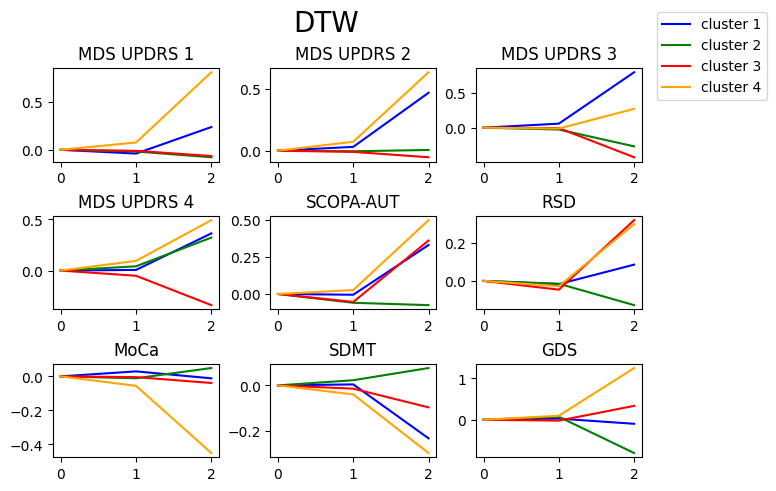

In [ ]:
#plot the cluster centers for visualization
fig, ax = plt.subplots(3,3, constrained_layout=True)
titles = ["MDS UPDRS 1", "MDS UPDRS 2", "MDS UPDRS 3","MDS UPDRS 4", "SCOPA-AUT", "RSD", "MoCa", "SDMT", "GDS"]
cols = ["blue","green","red","orange"]
for i in range(9):
    ax[i//3, i%3].set_title(titles[i])
    for j in range(4):
        ax[i//3, i%3].plot(model.cluster_centers_[j,:,i], c=cols[j])

labels = ["cluster 1", "cluster 2", "cluster 3","cluster 4"]
fig.legend([ax for ax in fig.axes], labels = labels, bbox_to_anchor = (1.2,1))
fig.suptitle("DTW", fontsize=20)

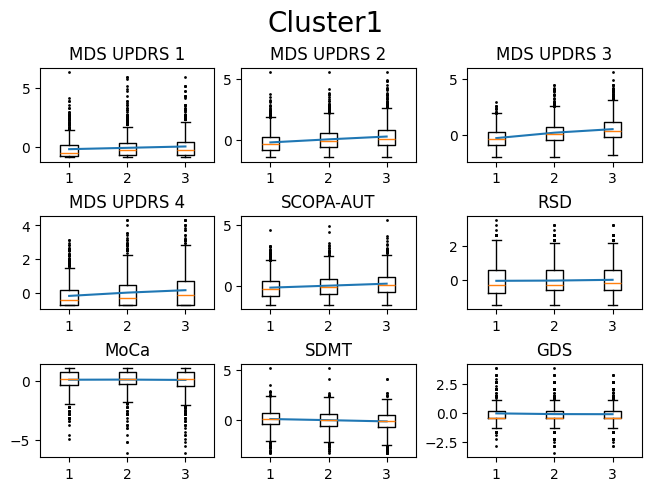

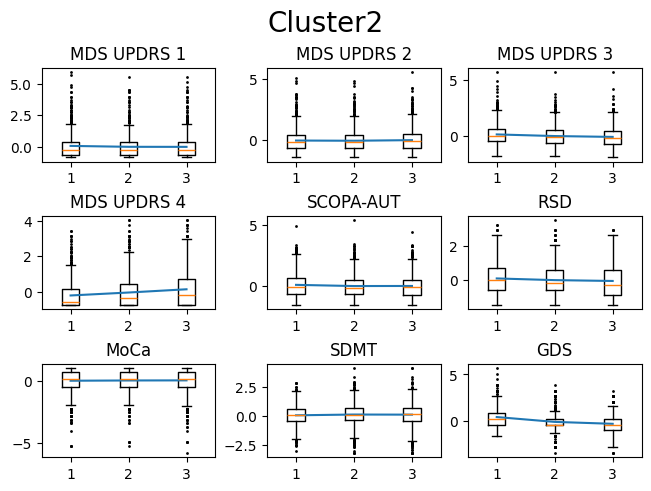

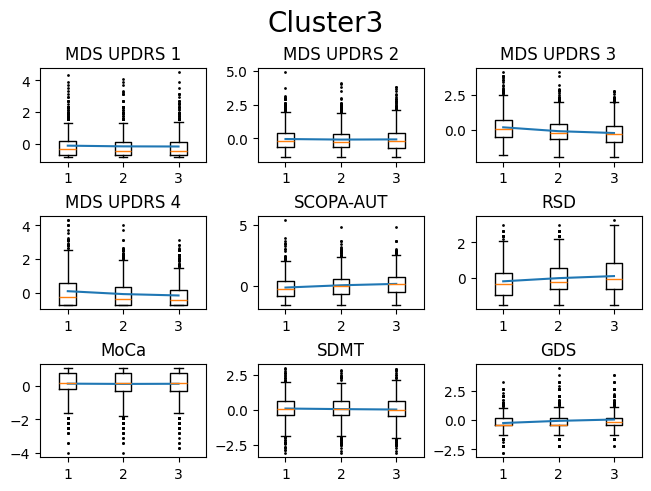

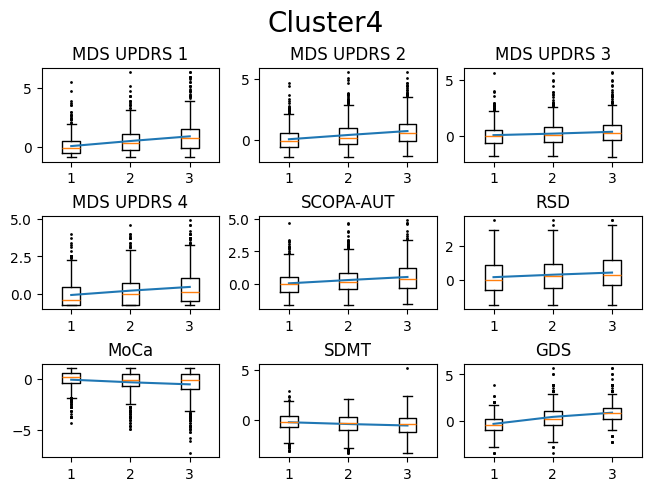

In [ ]:
#cluster summary plot for visualization
def Clustersummary(i):
    x_ = X[model.labels_ == i]
    fig, ax = plt.subplots(3,3, constrained_layout=True)
    for j in range(9):
        ax[j//3, j%3].set_title(titles[j])
        ax[j//3, j%3].boxplot([x_[:,0,j], x_[:,1,j], x_[:,2,j]], flierprops={'marker': 'o', 'markersize': 1})
        ax[j//3, j%3].plot([1,2,3], [np.mean(x_[:,0,j]), np.mean(x_[:,1,j]), np.mean(x_[:,2,j])])
    fig.suptitle(f'Cluster{ i+1}', fontsize=20)

for i in range(4): Clustersummary(i)

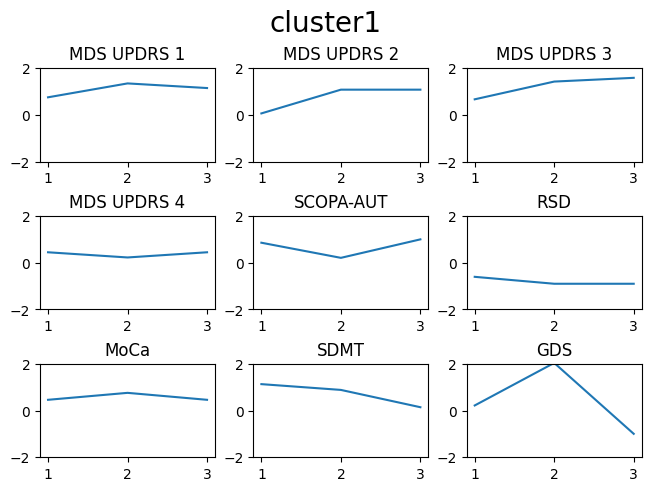

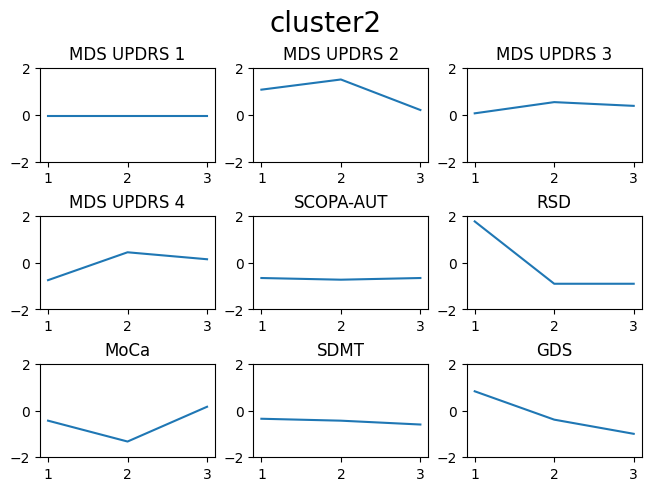

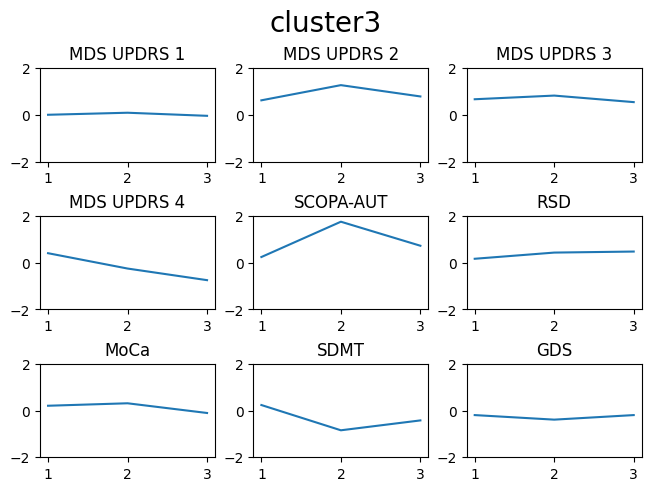

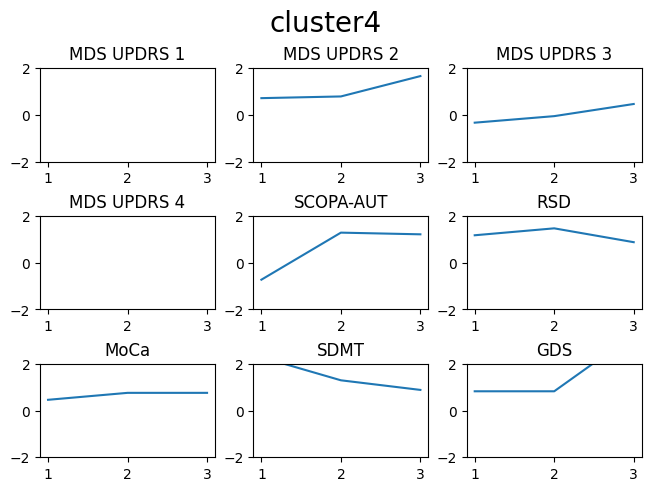

In [ ]:
#Samples from each clusters for visualization
def ClusterSample(i):
    idx = list(range(X.shape[0]))
    tmp = random.choice([idx[x] for x in range(X.shape[0]) if model.labels_[x] == i])

    fig, ax = plt.subplots(3,3, constrained_layout=True)
    for j in range(9):
        ax[j//3, j%3].set_title(titles[j])
        ax[j//3, j%3].plot([1,2,3], [np.mean(X[tmp,0,j]), np.mean(X[tmp,1,j]), np.mean(X[tmp,2,j])])
        ax[j//3, j%3].set_ylim([-2,2])

    fig.suptitle(f'cluster{i+1}', fontsize=20)

for i in range(4): ClusterSample(i)

In [ ]:
#export the clustered results
pd.DataFrame(model.labels_).to_csv("dataset/generated_data/DTW.csv")